In [1]:
# Demo-ing the classification pipeline
import os

In [2]:
%%time
# Example 1: Pre-classified lidar and binary outputs
from shelterbelts.classifications.lidar import lidar
laz_file = '../data/Young201709-LID1-C3-AHD_6306194_55_0002_0002.laz'
outdir = '../outdir'

stub = 'pre-classified-trees'
category5 = True  # This means we use their pre-labelled point classifications for trees > 2m 
binary = True   
resolution = 1   # metres (horizontal)

da1 = lidar(laz_file, outdir, stub, resolution, category5=category5, binary=True)

Saved: ../outdir/pre-classified-trees_counts_res1_cat5.tif
Saved: ../outdir/pre-classified-trees_woodyveg_res1_cat5.tif
CPU times: user 22.9 s, sys: 2.81 s, total: 25.7 s
Wall time: 15.5 s


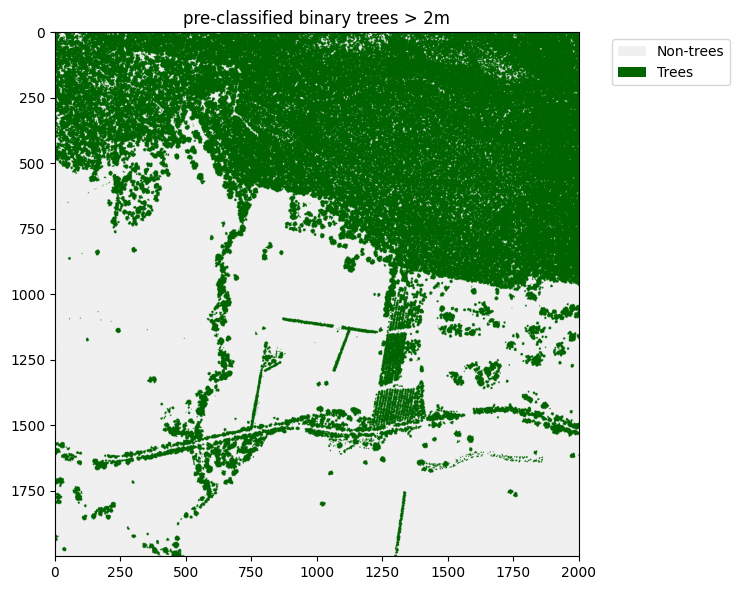

In [3]:
from shelterbelts.apis.worldcover import visualise_categories, tif_categorical
from shelterbelts.util.binary_trees import cmap_woody_veg, labels_woody_veg
visualise_categories(da1, None, cmap_woody_veg, labels_woody_veg, "pre-classified binary trees > 2m")

In [4]:
%%time
# Example 2: Creating our own canopy height model and percentage tree cover outputs
stub = 'our-trees'
category5 = False  # This means we generate our own canopy height model (instead of using their pre-labelled tree classifications)
binary = False   # This means we calculate percentage tree cover instead of just binary labels
height_threshold = 2  # metres (vertical)
resolution = 10       # metres (horizontal)

da2 = lidar(laz_file, outdir, stub, resolution, height_threshold=height_threshold, category5=category5, binary=binary)

Saved: ../outdir/our-trees_chm_res1.tif
Saved: ../outdir/our-trees_percentcover_res10_height2m.tif
CPU times: user 42.5 s, sys: 2.38 s, total: 44.9 s
Wall time: 41.5 s


In [5]:
# Converting to a binary tif with a specific percent cover threshold
percent_cover_threshold = 10

da2_binary = da2 > percent_cover_threshold 
filename = os.path.join(outdir, f'{stub}_{height_threshold}m_{percent_cover_threshold}p.tif')
tif_categorical(da2_binary, filename, cmap_woody_veg)

Saved: ../outdir/our-trees_2m_10p.tif


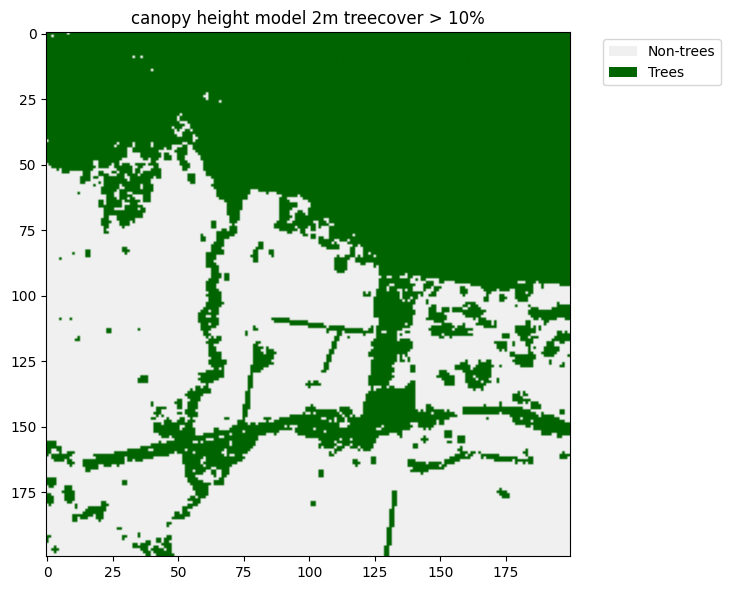

In [14]:
visualise_categories(da2_binary, None, cmap_woody_veg, labels_woody_veg, "canopy height model 2m treecover > 10%")

In [7]:
%%time
# Downloading sentinel imagery for the same area as this tree tif
from shelterbelts.classifications.sentinel_dea import download_ds2

tree_file = '../outdir/our-trees_2m_10p.tif'
start_date="2020-01-01"
end_date="2021-01-01"
ds2 = download_ds2(tree_file, start_date, end_date, outdir)

Saved ../outdir/our-trees_2m_10p_ds2_2020-01-01.pkl
CPU times: user 2min 15s, sys: 43.9 s, total: 2min 59s
Wall time: 6min 49s


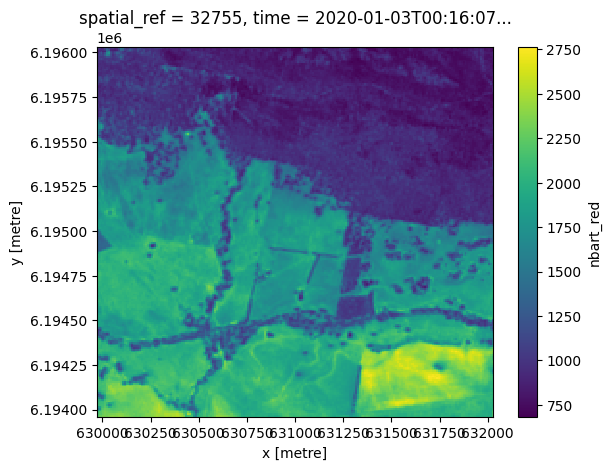

In [8]:
# Example band at a specific timepoint
ds2['nbart_red'].isel(time=0).plot()

In [9]:
%%time
# Merging the satellite imagery and tree raster
from shelterbelts.classifications.merge_inputs_outputs import tile_csv

sentinel_file = '../outdir/our-trees_2m_10p_ds2_2020-01-01.pkl'
radius = 4   # Radius of the kernel used for spatial variance
spacing = 1  # Distance between each point chosen for training/testing

df = tile_csv(sentinel_file, tree_file, outdir, radius, spacing)  # I'd like to add an option to use the geometric median like Dale Roberts, and best monthly cloud free imagery like Martin Brandt
df

Loading ../outdir/our-trees_2m_10p_ds2_2020-01-01.pkl
Loading ../outdir/our-trees_2m_10p.tif


/Users/christopherbradley/miniconda3/envs/shelterbelts_pdal/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


Saved: ../outdir/our-trees_2m_10p_df_r4_s1.csv
CPU times: user 4.76 s, sys: 747 ms, total: 5.51 s
Wall time: 5.68 s


,tree_cover,nbart_blue_temporal_median,nbart_blue_temporal_std,nbart_blue_focal_mean,nbart_blue_focal_std,nbart_green_temporal_median,nbart_green_temporal_std,nbart_green_focal_mean,nbart_green_focal_std,nbart_red_temporal_median,...,NDVI_focal_mean,NDVI_focal_std,GRNDVI_temporal_median,GRNDVI_temporal_std,GRNDVI_focal_mean,GRNDVI_focal_std,spatial_ref,y,x,tile_id
0,1.0,313.0,286.563446,406.895050,148.753926,455.0,307.635254,587.709900,198.177802,581.0,...,0.514107,0.088375,0.672573,0.062099,0.661770,0.037345,0,6195996.0,630005.0,our-trees_2m_10p
1,1.0,342.0,281.466125,403.234558,144.001449,514.5,298.928162,584.882690,190.070025,612.5,...,0.523450,0.086434,0.682504,0.060476,0.665383,0.036725,0,6195996.0,630015.0,our-trees_2m_10p
2,1.0,654.5,305.264221,403.481476,130.957763,929.0,339.446838,588.018494,173.960917,1200.0,...,0.531951,0.086597,0.610213,0.052799,0.668700,0.035514,0,6195996.0,630025.0,our-trees_2m_10p
3,1.0,806.0,318.476624,408.506165,129.590753,1102.5,373.002869,598.716064,172.230888,1473.5,...,0.532804,0.089784,0.569632,0.033537,0.668309,0.036692,0,6195996.0,630035.0,our-trees_2m_10p
4,1.0,453.5,300.624725,416.086426,129.234253,637.0,328.584137,611.993835,173.205980,799.5,...,0.531032,0.092640,0.621759,0.057962,0.667013,0.038375,0,6195996.0,630045.0,our-trees_2m_10p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.0,405.5,418.099823,405.802460,14.679178,817.0,367.478577,805.327148,14.491445,576.0,...,0.742368,0.013230,0.688524,0.088066,0.691955,0.005829,0,6194006.0,631955.0,our-trees_2m_10p
39996,0.0,412.0,433.086945,402.407410,13.830048,810.5,367.200165,801.438293,17.724803,570.5,...,0.740443,0.014081,0.692363,0.087252,0.691690,0.004883,0,6194006.0,631965.0,our-trees_2m_10p
39997,0.0,405.0,440.245331,399.370361,13.101630,797.5,389.374115,797.944458,19.245780,567.0,...,0.738752,0.013751,0.689374,0.089158,0.691532,0.004911,0,6194006.0,631975.0,our-trees_2m_10p
39998,0.0,399.0,432.417664,396.351868,13.249538,792.0,391.805084,794.438293,18.408289,590.5,...,0.736568,0.014600,0.689911,0.089805,0.691164,0.004888,0,6194006.0,631985.0,our-trees_2m_10p


2025-09-04 18:42:03.526159: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Original number of samples: 39952
tree_cover
0.0           20647
1.0           19305
Name: count, dtype: int64


Number of training samples: 27026
tree_cover
0.0           13513
1.0           13513
Name: count, dtype: int64


Number of testing samples: 11584
tree_cover
0.0           5792
1.0           5792
Name: count, dtype: int64
Saved ../outdir/our-trees_scaler.pkl
Epoch 1/20
845/845 - 6s - 7ms/step - CategoricalAccuracy: 0.9560 - loss: 0.1140 - val_CategoricalAccuracy: 0.9649 - val_loss: 0.0868
Epoch 2/20
845/845 - 2s - 3ms/step - CategoricalAccuracy: 0.9690 - loss: 0.0851 - val_CategoricalAccuracy: 0.9682 - val_loss: 0.0822
Epoch 3/20
845/845 - 3s - 3ms/step - CategoricalAccuracy: 0.9704 - loss: 0.0785 - val_CategoricalAccuracy: 0.9701 - val_loss: 0.0814
Epoch 4/20
845/845 - 2s - 3ms/step - CategoricalAccuracy: 0.9708 - loss: 0.0764 - val_CategoricalAccuracy: 0.9709 - val_loss: 0.0769
Epoch 5/20
845/845 - 2s - 3ms/step - CategoricalAccuracy: 0.9722 - loss: 0.0725 - val_Categorical

,tree_class,precision,recall,f1-score,accuracy,support
0,0.0,0.966246,0.978591,0.972379,0.972203,5792.0
1,1.0,0.978314,0.965815,0.972024,0.972203,5792.0


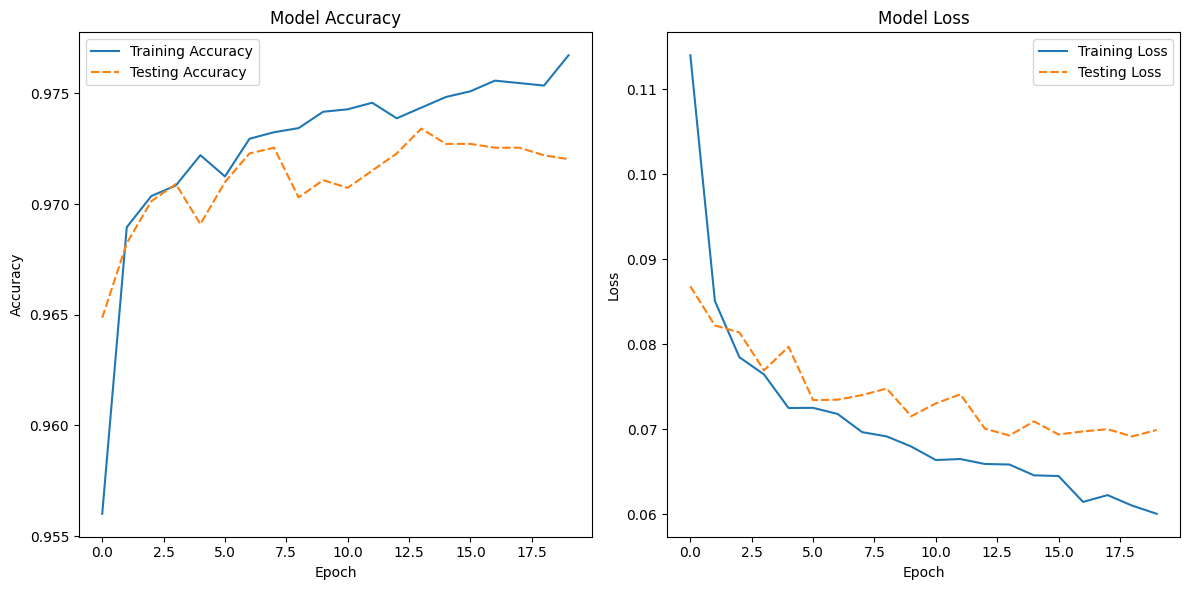

In [10]:
%%time
# Training a neural network
from shelterbelts.classifications.neural_network import neural_network

training_file = '../outdir/our-trees_2m_10p_df_r4_s1.csv'
stratification_columns = ['tree_cover']

# Very high accuracy because we're just predicting on a single 2km x 2km tile in this example
neural_network(training_file, outdir, stub, output_column='tree_cover', drop_columns=['x', 'y', 'tile_id', 'spatial_ref'], stratification_columns=stratification_columns, epochs=20)  # I'd like to add an option to use a random forest, alpha earth embeddings, dinov3 embeddings, and shap values.


In [11]:
from shelterbelts.apis.worldcover import visualise_categories, tif_categorical
from shelterbelts.util.binary_trees import cmap_woody_veg, labels_woody_veg
tree_file = '..outdir/our-trees_2m_10p.tif'
outdir = '../outdir'
sentinel_file = '../outdir/our-trees_2m_10p_ds2_2020-01-01.pkl'

In [12]:
%%time
# Predicting new locations
from shelterbelts.classifications.predictions_batch import tif_prediction
filename_scaler = '../outdir/our-trees_scaler.pkl'
filename_model = '../outdir/our-trees_nn.keras'

da_predicted = tif_prediction(sentinel_file, outdir, filename_model, filename_scaler)

/Users/christopherbradley/miniconda3/envs/shelterbelts_pdal/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


1333/1333 ━━━━━━━━━━━━━━━━━━━━ 1s 817us/step
Saved: ../outdir/our-trees_2m_10p_ds2_2020-01-01_predicted.tif
CPU times: user 3.66 s, sys: 586 ms, total: 4.25 s
Wall time: 4.16 s


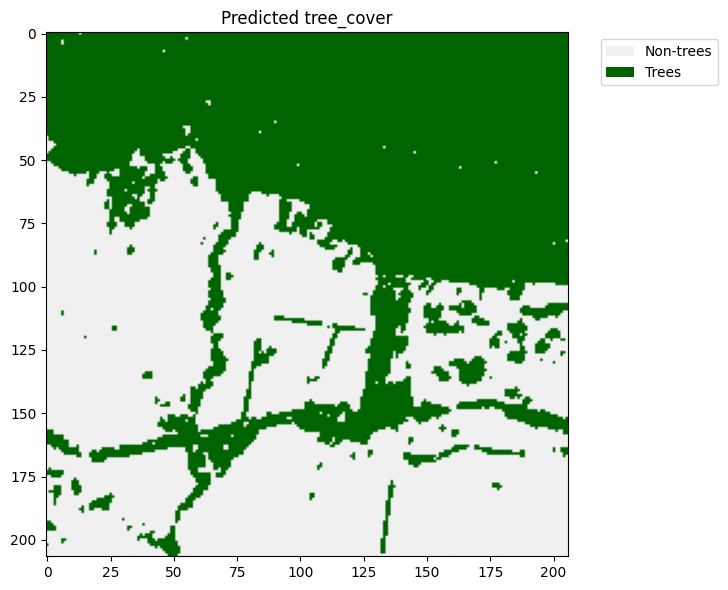

In [13]:
# Plotting the predicted trees
visualise_categories(da_predicted, None, cmap_woody_veg, labels_woody_veg, "Predicted tree_cover")